<a href="https://colab.research.google.com/github/HernanDL/Noise-Cancellation-Using-GenAI/blob/main/ANC_Simple_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from google.colab import files
import io

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [34]:
# Upload and load the audio file
print("Please upload your noise .wav file:")
uploaded = files.upload()

Please upload your noise .wav file:


Saving Bn-ord-B3-mf-N-N.wav to Bn-ord-B3-mf-N-N (1).wav


Bn-ord-B3-mf-N-N (1).wav
SimpleCNN(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(64, 1, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
)
Epoch [1/20], Loss: 0.0110071
Epoch [2/20], Loss: 0.0009530
Epoch [3/20], Loss: 0.0008119
Epoch [4/20], Loss: 0.0007525
Epoch [5/20], Loss: 0.0006475
Epoch [6/20], Loss: 0.0004057
Epoch [7/20], Loss: 0.0001152
Epoch [8/20], Loss: 0.0000190
Epoch [9/20], Loss: 0.0000080
Epoch [10/20], Loss: 0.0000041
Epoch [11/20], Loss: 0.0000033
Epoch [12/20], Loss: 0.0000030
Epoch [13/20], Loss: 0.0000029
Epoch [14/20], Loss: 0.0000028
Epoch [15/20], Loss: 0.0000027
Epoch [16/20], Loss: 0.0000026
Epoch [17/20], Loss: 0.0000026
Epoch [18/20], Loss: 0.0000025
Epoch [19/20], Loss: 0.0000025
Epoch [20/20], Loss: 0.0000024


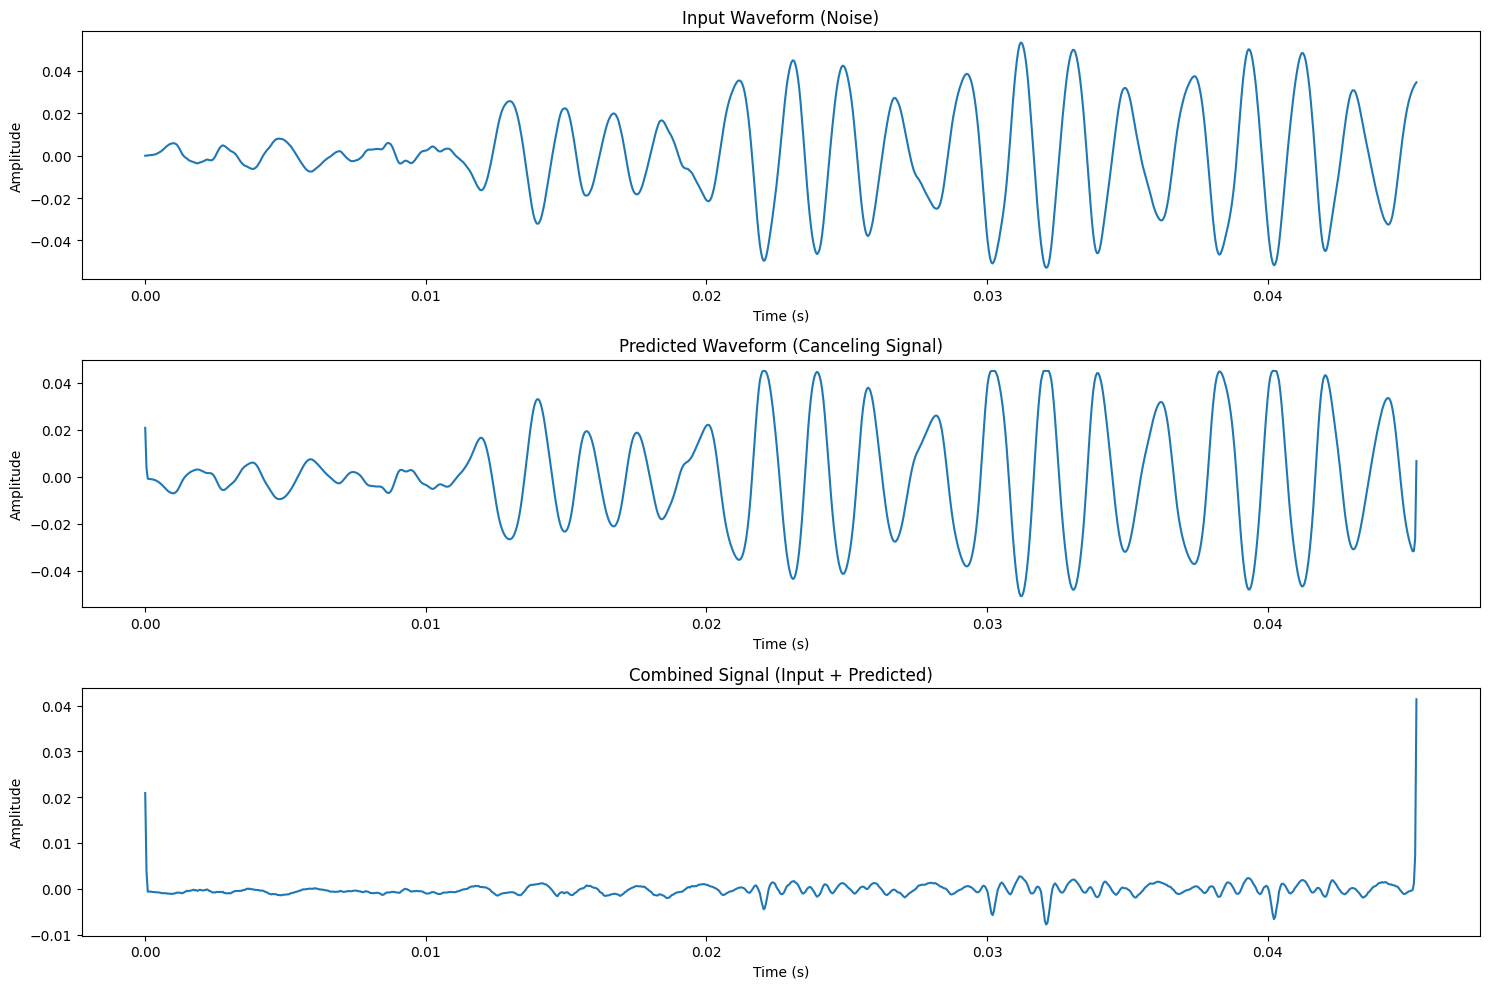

Noise reduction: 21.66 dB


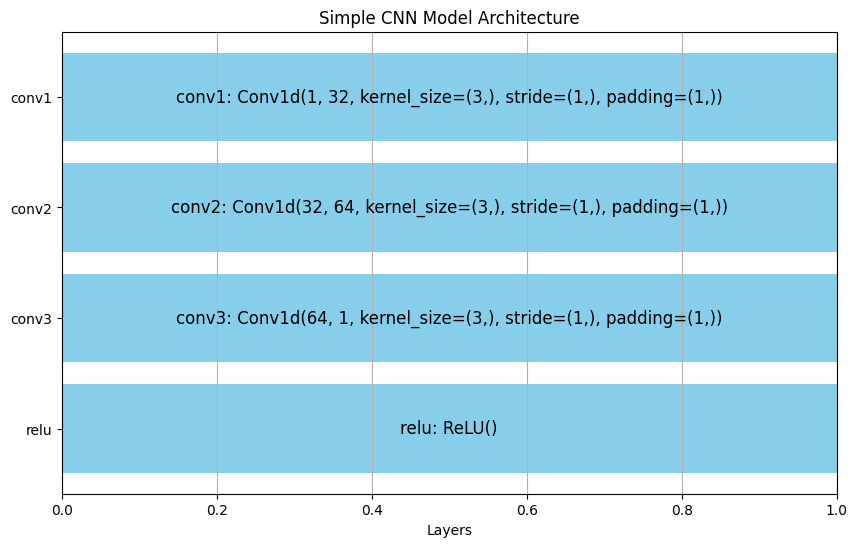

In [35]:
file_name = list(uploaded.keys())[0]
print(file_name)

def load_and_preprocess_audio(file_obj, sr=22050, duration=5):
    audio_data = file_obj.read()
    y, _ = librosa.load(io.BytesIO(audio_data), sr=sr, duration=duration)
    return y

audio = load_and_preprocess_audio(io.BytesIO(uploaded[file_name]))

# Data preprocessing
def create_dataset(audio, seq_length=1000, stride=100):
    X, y = [], []
    for i in range(0, len(audio) - seq_length, stride):
        X.append(audio[i:i+seq_length])
        y.append(-audio[i:i+seq_length])  # Inverted signal for noise cancellation
    return np.array(X), np.array(y)

X, y = create_dataset(audio)
X_tensor = torch.FloatTensor(X).unsqueeze(-1)
y_tensor = torch.FloatTensor(y)

# Create DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Define the model
class SimpleCNN(nn.Module):
    def __init__(self, input_channels=1, output_channels=1):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, output_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.transpose(1, 2)  # Change shape from (batch, seq_len, channels) to (batch, channels, seq_len)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x.transpose(1, 2)  # Change back to (batch, seq_len, channels)

# Initialize the model
model = SimpleCNN()
print(model)

# Training function
def train_model(model, dataloader, num_epochs=20, learning_rate=0.01):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            output = model(batch_X)
            loss = criterion(output.squeeze(-1), batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        #if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataloader):.7f}')

# Train the model
train_model(model, dataloader)

# Evaluation and visualization function
def predict_and_visualize(model, audio, seq_length=1000):
    model.eval()
    with torch.no_grad():
        input_tensor = torch.FloatTensor(audio[:seq_length]).unsqueeze(0).unsqueeze(-1)
        predicted = model(input_tensor).squeeze().numpy()

    # Plot results
    t = np.arange(seq_length) / 22050  # Assuming 22050 Hz sample rate
    plt.figure(figsize=(15, 10))

    plt.subplot(3, 1, 1)
    plt.plot(t, audio[:seq_length])
    plt.title('Input Waveform (Noise)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    plt.subplot(3, 1, 2)
    plt.plot(t, predicted)
    plt.title('Predicted Waveform (Canceling Signal)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    plt.subplot(3, 1, 3)
    combined = audio[:seq_length] + predicted
    plt.plot(t, combined)
    plt.title('Combined Signal (Input + Predicted)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

    # Calculate and print the reduction in signal power
    input_power = np.mean(np.square(audio[:seq_length]))
    output_power = np.mean(np.square(combined))
    reduction_db = 10 * np.log10(input_power / output_power)
    print(f"Noise reduction: {reduction_db:.2f} dB")

# Evaluate and visualize results
predict_and_visualize(model, audio)

